In [2]:
import scipy as sp
import numpy as np
import scipy.sparse as sps
import scipy.sparse.linalg as spla
import scipy.linalg as sla

import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Лабораторная работа 2. SVD

## 1. Волшебные невязки (2 балла)

Сгенерируйте командой `scipy.linalg.hilbert` матрицу Гильберта размера $500\times500$. Назовём эту матрицу $A$. 

Возьмите вектор $z = (0,0,\ldots,0,1)\in\mathbb{R}^{500}$. Вычислите $b = Az$ и решите систему уравнений $Ax = b$ вашим любимым способом.

Теперь исказите вектор $b$ небольшой (по модулю не большей $0.0001$ по каждой координате) случайной ошибкой и для полученного вектора $b'$ решите систему $Ax = b'$ тем же самым способом.

Сравните невязки $||A\hat{x} - b||_2$ и $||A\hat{x}' - b'||_2$, где $\hat{x}$ и $\hat{x}'$ - полученные вами решения. Попробуйте объяснить эффект.

**Важно!** Баллы будут ставиться не за реализацию, а за объяснения!

In [272]:
def solve_naive(A, b):
    return b.dot(sla.inv(A))


def solve_standart(A, b):
    return sla.solve(A, b)


def test(test_name, A, b1, b2, solver):
    print('test for', test_name)
    x1 = solver(A, b1)
    x2 = solver(A, b2)
    print('||A * x1 - b1|| =', sla.norm(A.dot(x1) - b1))
    print('||A * x2 - b2|| =', sla.norm(A.dot(x2) - b2))

size = 500
A = sla.hilbert(size)
print('||A|| * ||A^-1|| =', sla.norm(A) * sla.norm(sla.inv(A)))
z = np.zeros(size)
z[size - 1] = 1
b1 = A.dot(z)
b2 = b1 + np.random.uniform(-1e-4, 1e-4, size)
test('naive solver', A, b1, b2, solve_naive)
test('standart solver', A, b1, b2, solve_standart)

||A|| * ||A^-1|| = 2.61349718893e+20
test for naive solver
||A * x1 - b1|| = 3.089599611705846
||A * x2 - b2|| = 0.3704901796315182
test for standart solver
||A * x1 - b1|| = 7.364429199875297e-15
||A * x2 - b2|| = 81.18131091215591


/home/ec2-user/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.6334739460792256e-21
  ' condition number: {}'.format(rcond), RuntimeWarning)


**Эффект**

Ничего удивительного нет в том, что умножение на обратную матрицу дает очень плохой результат. При обращении большой матрицы Гильберта возникает огромная погрешность.

Более интересный эффект, почему стандартный sla.solve умеет обращать решение точно. Нет никакой разницы какой вектор $z$ генерировать. Результат одинаковый. Если $b = A \cdot z$, то система решается очень точно. В противном случае возникает большая погрешность.

**Объяснение**

Для решения систем используется метод наименьших квадратов. Согласно теории, $$\frac{||\Delta x||}{||x||} \leq \epsilon \cdot f(A, b)$$
где $f(A, b)$ --- число обусловенности для метода наименьших квадратов с параметрами $A$ и $b$, а $\epsilon$ --- возмущение решения. Так как в первом случае $b$ мы строили по готовому решению, то $\epsilon = 0$ (с машинной точностью). Поэтому в этом случае систему получается решить точно, а в другом нет.

## 2. Неожиданно теоретическая задача (2 балла)

Для двух заданных матриц $A$ и $B$ одного размера найдите ортогональную матрицу $Q$, для которой норма Фробениуса разности $||QA - B||_F$ минимальна.

In [106]:
A = np.random.rand(3, 5)
A

array([[ 0.08917802,  0.45694658,  0.78339017,  0.52322029,  0.573839  ],
       [ 0.08840711,  0.6386738 ,  0.44789706,  0.2973181 ,  0.3857738 ],
       [ 0.23878344,  0.86444661,  0.33560406,  0.91888558,  0.36274416]])

In [107]:
x = (A * A).sum()
x

4.1799046075518413

In [109]:
y = np.trace(A.dot(A.transpose()))
y

4.1799046075518405

In [ ]:
---
*Ваше решение*

## 3. Сжатие информации с помощью SVD (3 балла)

Загрузите фотографию sonya.jpg.

Поскольку фотография чёрно-белая, её можно проинтерпетировать как матрицу, элементы которой - это насыщенность серого цвета каждого из пикселей. Постройте сингулярное разложение этой матрицы (не нужно центрировать данные!). 

Визуализуйте первую главную компоненту. Ожидали ли вы увидеть именно это? Почему?

Визуализуйте компонеты с первой по двадцатую, с первой по пятидесятую, с двадцатой по сотую, с двадцатой по последнюю. Сделайте выводы.

Как вам кажется, сколько первых компонент нужно взять для достаточно хорошего восстановления исходного изображения? Во сколько раз меньше памяти потребуется для их хранения? Как изменится результат, если сначала вы центрируете данные?

**Важное замечание.** Главные компоненты - это не скрытые признаки, а матрицы вида $u^{(i)}\sigma_i(v^{(i)})^T$, где $u^{(i)}, v^{(i)}$ --- столбцы матриц $U$ и $V$ соответственно. В частности, сумма первых нескольких главных компонент --- это наилучшее приближение исходной матрицы матрицей данного ранга.

### Решение

Загрузим изображение

In [323]:
from PIL import Image
from scipy import misc


img = misc.imread(r'sonya.jpg', mode='L') # это матрица из интенсивностей серого цвета; её уже можно подвергать SVD

Посмотрим на Соню!

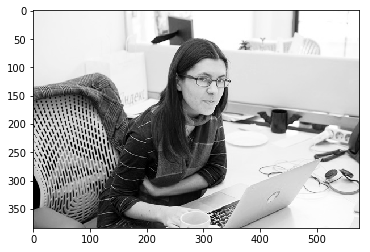

In [324]:
imgplot = plt.imshow(img, cmap='Greys_r')

In [343]:
U, s, V = np.linalg.svd(img, full_matrices=False)

In [346]:
def viz(a, b, mean_row=None):
    apr_I = np.zeros_like(I)
    for i in range(a, b):
        u = U.transpose()[i]
        u = u.reshape(u.shape + (1,))
        v = V[i]
        v = v.reshape((1,) + v.shape)
        apr_I += u.dot(v) * s[i]
    if mean_row is not None:
        apr_I += mean_row
    print('a = {} b = {} norm = {}'.format(a, b, sla.norm(img - apr_I)))
    mgplot = plt.imshow(apr_I, cmap='Greys_r')

a = 0 b = 1 norm = 27477.192558463812


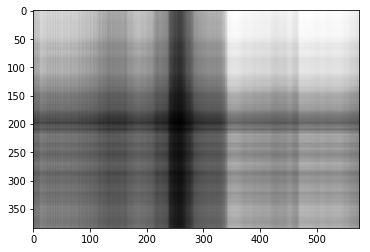

In [347]:
viz(0, 1, None)

Эта матрица --- произведение двух векторов интенсивности серого. Поэтому распределение в ней --- это выпуклая двумерная функция. Четко виден максимум.

In [348]:
viz(0, 20)

a = 0 b = 20 norm = 9579.76847828787


In [349]:
viz(0, 50)

a = 0 b = 50 norm = 5171.904089643245


In [350]:
viz(20, 100)

a = 20 b = 100 norm = 82059.53334787894


a = 20 b = 384 norm = 82016.86238147864


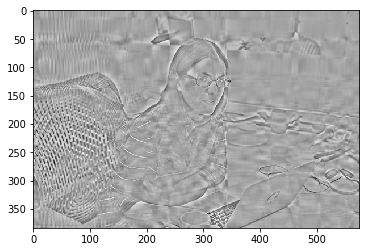

In [351]:
viz(20, len(s))

Первые компоненты обладают большей дисперсией, поэтому при вызове `viz(0, 20)` некоторые участки размазаны, зато почти полностью передан цвет. В то же время, при вызове `viz(20, 100)` видно много деталей, но изображение полностью серое, т.к. дисперсия этих компонент уже небольшая.

По-хорошему, "достаточно хорошее качество" стоит определять метрикой, но без достаточной интуиции любая метрика ничего не скажет. Поэтому я подбирал количество на глаз. Для первых 60 компонент вполне хорошее качество картинки. Не хуже чем на facebook :) При хранении первых 60 компонент сжатие происходит в 5 раз.

a = 0 b = 60 norm = 4429.898257236803
usage ratio = 0.20860460069444445


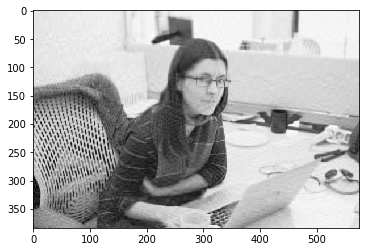

In [352]:
size = 60
viz(0, size)
usage = size + U.shape[1] * size + V.shape[0] * size
print('usage ratio =', usage / img.size)

In [354]:
mean_row = img.mean(axis=0)
norm_img = img - mean_row
U, s, V = np.linalg.svd(norm_img, full_matrices=False)
viz(0, 20, mean_row)

a = 0 b = 20 norm = 9397.51021124894


Центрирование чуть-чуть помогает улучшить качество изображения. До него норма была `9579`, после `9397`. Разница около 1%.

## 4. Снижение размерности с помощью SVD (4 балла)

Загрузите со страницы курса файлы `messages_texts.txt`, `messages_features.txt` и `messages_vectorized.mtx`.

**Внимание!** Не пытайтесь открыть файл `messages_vectorized.txt` в блокноте или, тем более, распечатать его в IPython ноутбуке. Сначала посмотрите на его объём.

* `messages_texts.txt` содержит некоторое количество текстовых сообщений на английском языке. Сообщение номер k начинается с заголовка post_number_k.
* `messages_features.txt` содержит список пар `(слово, номер соответствующего признака)` для всех слов, которые содержатся в теле сообщений, кроме самых употребительных из списка `stopwords.words("english")`
* `messages_vectorized.mtx` содержит разреженную матрицу, содержащая индексы [tf-idf](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) всех слов из messages_features в каждом сообщении.

*Замечание* Не обязательно парсить файл `messages_texts.txt`; чтобы найти сообщение с нужным номером, вы можете просто воспользоваться поиском по файлу!

В этом задании вы попробуете представить сообщения векторами небольшой размерности. Идея вот в чём. Изначально каждое сообщение у нас представлена огромным количеством признаков: tf-idf индексами всех слов. SVD позволяет значительную часть информации собрать в нескольких новых признаках; тем самым, сообщения будут представлены достаточно короткими векторами.

Загрузите матрицу `messages_vectorized.mtx`. Поскольку она очень большая, не пытайтесь вычислять полное SVD; вместо этого воспользуйтесь функцией [scipy.linalg.svds](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.linalg.svds.html#scipy.sparse.linalg.svds), которая вычисляет $k$ старших сингулярных значений и векторов. Возьмите $k = 6$ и визуализуйте сообщения в пространстве первых трёх новых признаков. Какие геометричские особенности датасета становятся видны? Стоят ли за этим какие-то содержательные закономерности? Возможно, придётся запустить несколько раз, чтобы получилась хорошая картинка (а она действительно хорошая!).

Какой методологический недочёт был допущен при создании матрицы `messages_vectorized.mtx`? Как он повлиял на поведение SVD?

Попытайтесь выяснить, какие из исходных признаков (то есть какие слова) вносят наибольший вклад в три новых признака.

Сравните результаты с тем, что получилось бы, если воспользоваться [случайными гауссовскими проекциями](http://scikit-learn.org/stable/modules/random_projection.html). Они вызываются следующими заклинаниями:

In [ ]:
X = # Your matrix
transformer = random_projection.GaussianRandomProjection(n_components='''how many?''')
X_new = transformer.fit_transform(X)

**Центрировать данные** можно с помощью функции `sklearn.preprocessing.scale`:

In [ ]:
from sklearn.preprocessing import scale
scale(X, with_mean = True, with_std=False, axis=0)

*P.S.* Если оперативная память вам позволит (кажется, 2Гб должно хватить), можете всё-таки попробовать сделать полное SVD и сравнить полученную картинку с той, что выдаёт `svds`.

In [ ]:
# Your code here

## 5. Blessing of dimensionality (3 балла)

Это в каком-то смысле продолжение задания 3; вы попробуете сжать временной ряд с помощью тензорных разложений (то есть сделать такие же картинки, как вам показывали на семинаре).

Загрузите временной ряд (если интересно, он взят [отсюда](https://www.quandl.com/data/BOE/XUDLNKG-Effective-Exchange-Rate-Index-Norwegian-Krone-1990-Average-100)) из файла `BOE-XUDLNKG.csv`

In [ ]:
import pandas as pd

x = pd.read_csv(r'BOE-XUDLNKG.csv')['Value'].as_matrix()
x = x[:10500]

Сожмите его несколькими способами:
- с помощью SVD (трансформировав в матрицу, близкую к квадратной), 
- с помощью HOSVD (трансформировав в тензор валентности 3, по возможности близкий к кубическому) 
- с помощью тензорного поезда.

Постарайтесь не только минимизировать ранги, но и добиться, чтобы относительная ошибка --- то есть $\frac{||x - x'||}{||x||}$ --- в каждом случае была не больше 0,05.

Нарисуйте восстановленные из сжатых тензоров ряды. Во сколько раз в каждом из способов удаётся уменьшить объём хранимых данных?

*Замечание* В этом задании не надо пользоваться никакими специальными библиотеками, только стандартными функциями (например, `np.tensordot`, `np.transpose`, `reshape`, `sla.svd`).

In [ ]:
# Your code here